In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
import statistics

In [2]:
mkfunc2 = lambda x, pos: "2/"+time.ctime(x+9*3600)[8:16]
mkformatter2 = matplotlib.ticker.FuncFormatter(mkfunc2)

In [3]:
with open("runtimes.csv","r") as fd: lines=fd.readlines()


In [4]:
def parse(lines, cpus=2, sstrs=["2"]):
    data={}
    for line in lines[1:]:
      larr=line.strip().split(",")
      #print(larr)
      if len(larr)!=9:
        continue

      found=False
      for sstr in sstrs:
        if larr[8].strip().startswith(sstr):
          found=True
      if not found:
        continue

      if int(float(larr[1].strip()))!=cpus:
        continue
        
      narr=larr[6].strip().split(".")
      n=narr[1] # node name
      d=narr[-1] #domain
      k = larr[3].strip()
      if k=="":
          kidx=int(larr[4].split('/')[1])
          if kidx<1:
            k="A100-SXM4-40GB MIG 7g.40gb"
          elif kidx<3:
            k="A100-SXM4-40GB MIG 3g.20gb"
          elif kidx<7:
            k="A100-SXM4-40GB MIG 2g.10gb"
          else:
            k="A100-SXM4-40GB MIG 1g.5gb"
      if d=="com": # google
        if n.find("ts")<0:
            mtype=n.split("-")[2]
        else:
            mtype=n.split("-")[3]
        k=k + " " + mtype
      else:
        k=k+ " prp"
      val=int(larr[7])

      if k not in data:
        data[k]=[]
      data[k].append(val)
    return data


In [5]:
def get_means(data, maxv=36000):
    means={}
    medians={}
    for k in data:
        els=[]
        for val in data[k]:
            if val<maxv: # strip out outliers
                els.append(val)
        means[k] = statistics.mean(els)
        medians[k] = statistics.median(els)
    return (means,medians)

In [6]:
def save(data,means,medians,fname):
    with open(fname,"w") as fd:
        fd.write("#GPU, mean, median\n")
        klist=list(data.keys())
        klist.sort()
        for k in klist:
            fd.write("#%s, %i, %i\n"%(k,means[k],medians[k]))
        fd.write("#GPU, walltime\n")
        for k in klist:
            for val in data[k]:
                fd.write("%s, %i\n"%(k,val))

In [7]:
def hvals(data, minv=0, maxv=36000, bins=20):
    rtimes=set()
    for k in data:
        rtimes = rtimes.union(data[k])

    rmin=max( (min(rtimes),minv) )
    rmax=min( (max(rtimes),maxv) )+1
    dr=(rmax-rmin)/float(bins)
    del rtimes
    
    data_times=[]
    data_values={}
    for k in data:
        data_values[k] = []
    for i in range(bins):
        data_times.append(int(rmin+dr/2+dr*i))
        for k in data:
            data_values[k].append(0)
    for k in data:
        nels=len(data[k])
        for ival in data[k]:
            val = min(max(rmin,ival),rmax-1) 
            b=int((val-rmin)/dr)
            data_values[k][b]+=1.0/nels
    return (data_times, data_values)

In [8]:
data=parse(lines, 2,["2022-03"])
means,medians=get_means(data)
save(data,means,medians,"runtimes.all_c2.csv")
rtimes,rvals=hvals(data,maxv=40000,bins=30)

In [9]:
#print(data.keys())
#print(rtimes)
#print(rvals)

   28 26133 26136 A100-SXM4-40GB MIG 1g.5gb pa100m7
   30 13206 13212 A100-SXM4-40GB MIG 2g.10gb pa100m3
  103  8926  8928 A100-SXM4-40GB MIG 3g.20gb pa100m2
  102  7248  7235 A100-SXM4-40GB MIG 7g.40gb pa100m1
    6 15365 15371 A100-SXM4-40GB pa100t4
   14 26781 26730 A100-SXM4-40GB pa100t7
   33  4456  4500 NVIDIA A100-PCIE-40GB prp


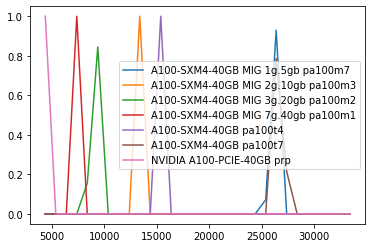

In [10]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

   72  7855  7848 Tesla V100-SXM2-16GB pv100
   37 14077 14220 Tesla V100-SXM2-16GB pv100t2
    9  6244  6228 Tesla V100-SXM2-32GB prp


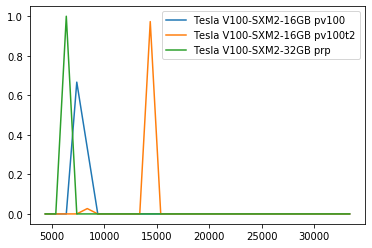

In [11]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

    3 11364 11340 Tesla T4 prp
   24 11472 11430 Tesla T4 pt4
   16 24612 24606 Tesla T4 pt4t2


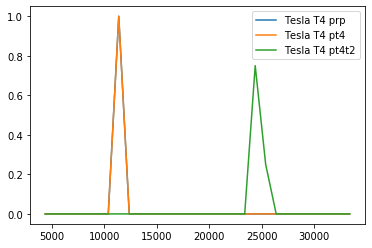

In [12]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

In [13]:
#data=parse(lines,2,"2022-03")
#means,medians=get_means(data)
#rtimes,rvals=hvals(data,bins=20)
#save(data,means,medians,"runtimes.prp_c2.csv")

   28 26133 26136 A100-SXM4-40GB MIG 1g.5gb pa100m7
   30 13206 13212 A100-SXM4-40GB MIG 2g.10gb pa100m3
  103  8926  8928 A100-SXM4-40GB MIG 3g.20gb pa100m2
  102  7248  7235 A100-SXM4-40GB MIG 7g.40gb pa100m1
    6 15365 15371 A100-SXM4-40GB pa100t4
   14 26781 26730 A100-SXM4-40GB pa100t7
   33  4456  4500 NVIDIA A100-PCIE-40GB prp
   73  4074  3996 NVIDIA A40 prp
  558  8868  8838 NVIDIA GeForce GTX 1080 Ti prp
  111 12383 12348 NVIDIA GeForce GTX 1080 prp
 1219  6409  6300 NVIDIA GeForce RTX 2080 Ti prp
   16  4900  5004 NVIDIA GeForce RTX 3090 prp
   14  8557  6624 NVIDIA TITAN RTX prp
   25  8180  8172 NVIDIA TITAN Xp prp
    3 11364 11340 Tesla T4 prp
   24 11472 11430 Tesla T4 pt4
   16 24612 24606 Tesla T4 pt4t2
   72  7855  7848 Tesla V100-SXM2-16GB pv100
   37 14077 14220 Tesla V100-SXM2-16GB pv100t2
    9  6244  6228 Tesla V100-SXM2-32GB prp


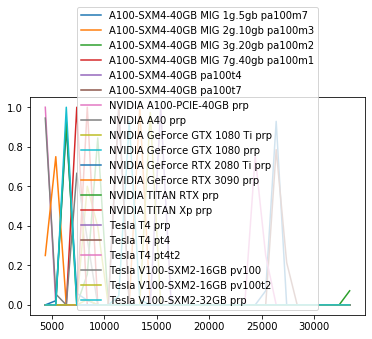

In [14]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    #if k.endswith("are"):
    #    continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

   73  4074  3996 NVIDIA A40 prp
  558  8868  8838 NVIDIA GeForce GTX 1080 Ti prp
  111 12383 12348 NVIDIA GeForce GTX 1080 prp
 1219  6409  6300 NVIDIA GeForce RTX 2080 Ti prp
   16  4900  5004 NVIDIA GeForce RTX 3090 prp
   14  8557  6624 NVIDIA TITAN RTX prp
   25  8180  8172 NVIDIA TITAN Xp prp


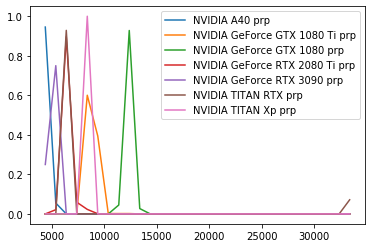

In [15]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("100")>0 or k.find("T4")>0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()